# Further explorations on the Citibike data2
- Location Mapping
- Heatmapping ridership

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.linear_model import LinearRegression, RANSACRegressor
%matplotlib inline

In [2]:
# Custom regression analysis method
def plot_MyLinearRegression(x, y, ax, xrange, ransac=False, loc='upper right', coeff=False,
                                                    xlabel=None, ylabel=None, title=None, xlim=None, ylim=None, fs=None):

    # Fit line using all data using regular Linear Regression
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)     # make x a vertical vector

    # Predict data of estimated models using simple LinearRegression
    line_X = np.arange(xrange[0], xrange[1], step=(xrange[1] - xrange[0])/20)
    line_y = model.predict(line_X[:, np.newaxis])
    if coeff:
        text_coeff = '(coeff = %.2f)' % model.coef_
    else:
        text_coeff = 'Fit'
    
    # Robustly fit linear model with RANSAC algorithm
    if ransac:
        model_ransac = RANSACRegressor(LinearRegression())
        model_ransac.fit(x.reshape(-1, 1), y)     # make x a vertical vector
        inlier_mask = model_ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)

        line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])
        if coeff:
            text_coeff_ransac = '(coeff = %.2f)' % model_ransac.estimator_.coef_
        else:
            text_coeff_ransac = ''

    lw = 3
    s=150
    if ransac:
        ax.scatter(x[inlier_mask], y[inlier_mask], s=s, color='blue', marker='.', label='Inliers', alpha=0.2)
        ax.scatter(x[outlier_mask], y[outlier_mask], s=s, color='yellowgreen', marker='.', label='Outliers', alpha=0.3)
        ax.plot(line_X, line_y, color='b', linestyle=':', linewidth=lw, label=('Linear ' + text_coeff), alpha=0.5)
        ax.plot(line_X, line_y_ransac, color='cornflowerblue', linestyle='--',linewidth=lw, label=('RANSAC ' + text_coeff_ransac), alpha=0.8)
    else:
        ax.scatter(x, y, s=s, color='blue', marker='.', alpha=0.2)
        ax.plot(line_X, line_y, color='b', linestyle=':', linewidth=lw, label=('Linear ' + text_coeff), alpha=0.5)
    
    ax.legend(loc=loc, fontsize=fs)
    ax.set_title(title, fontsize=fs)
    ax.set_xlabel(xlabel, fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

<b> Importing the datasets and comining into one</b>

In [3]:
# Importing data
d1 = pd.read_csv('../data/processed/extended2/p_s_alltime_extended.csv')
d2 = pd.read_csv('../data/processed/extended2/p_ns_alltime_extended.csv')

In [4]:
# data wrangling
data = pd.concat([d1, d2], axis=0)
del data['Unnamed: 0']
del data['DATE']
data = data[data['AWND'] >= 0]

In [5]:
data.columns

Index(['date', 'pickups', 'st_id', 'st_name', 'st_latitude', 'st_longitude',
       'closest_college', 'closest_college_distance', 'closest_subway',
       'closest_subway_distance', 'closest_theater',
       'closest_theater_distance', 'closest_museum', 'closest_museum_distance',
       'closest_park_name', 'closest_park_distance', 'PRCP', 'SNOW', 'SNWD',
       'TMAX', 'TMIN', 'AWND'],
      dtype='object')

In [6]:
data.head()

,date,pickups,st_id,st_name,st_latitude,st_longitude,closest_college,closest_college_distance,closest_subway,closest_subway_distance,...,closest_museum,closest_museum_distance,closest_park_name,closest_park_distance,PRCP,SNOW,SNWD,TMAX,TMIN,AWND
0,20130701,47,72,W 52 St & 11 Ave,40.767272,-73.993929,American Academy Mcallister Institute Of Funer...,0.449863,8th Ave & 50th St at NW corner,0.836766,...,Intrepid Sea-Air-Space Museum,0.648424,De Witt Clinton Park,0.190527,21.3,0.0,0.0,25.0,22.2,1.4
1,20130701,73,79,Franklin St & W Broadway,40.719116,-74.006667,Borough Of Manhattan Comm College (Cuny),0.438224,West Broadway & Franklin St at SW corner,0.012754,...,Jackie Robinson Museum,0.470931,GREENSTREET,0.154135,21.3,0.0,0.0,25.0,22.2,1.4
2,20130701,13,82,St James Pl & Pearl St,40.711174,-74.000165,Pace University / New York City Campus,0.390559,Centre St & Chambers St at SE corner,0.372382,...,South Street Seaport Museum,0.590027,James Madison Plaza,0.143915,21.3,0.0,0.0,25.0,22.2,1.4
3,20130701,19,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,Long Island University / Brooklyn Campus,0.970719,4th Ave & Pacific St at NE corner,0.176488,...,Museum of Contemporary African Diasporan Arts ...,0.224781,Brooklyn Academy Of Music,0.108015,21.3,0.0,0.0,25.0,22.2,1.4
4,20130701,47,116,W 17 St & 8 Ave,40.741776,-74.001497,New School University / Jazz And Contemporary ...,0.717327,8th Ave & 16th St at NW corner,0.062889,...,Rubin Museum of Art,0.368229,Dr. Gertrude B. Kelly Playground,0.170808,21.3,0.0,0.0,25.0,22.2,1.4


In [7]:
data.describe().round(2)

,date,pickups,st_id,st_latitude,st_longitude,closest_college_distance,closest_subway_distance,closest_theater_distance,closest_museum_distance,closest_park_distance,PRCP,SNOW,SNWD,TMAX,TMIN,AWND
count,927184.00,927184.00,927184.00,926658.00,926658.00,926658.00,926658.00,926658.00,926658.00,926658.00,927184.00,927184.00,927184.00,927184.00,927184.00,927184.00
mean,20151089.71,41.66,969.03,40.73,-73.98,0.66,0.28,1.12,0.66,0.15,2.70,1.34,10.23,18.39,10.28,2.33
std,11423.29,55.11,1129.51,0.03,0.02,0.42,0.23,1.27,0.63,0.03,7.61,12.26,48.83,9.91,9.19,1.01
min,20130701.00,1.00,72.00,40.52,-74.03,0.02,0.00,0.01,0.02,0.09,0.00,0.00,0.00,-9.30,-18.20,0.30
25%,20140816.00,6.00,315.00,40.71,-74.00,0.33,0.09,0.25,0.27,0.13,0.00,0.00,0.00,10.60,3.30,1.60
50%,20150924.00,19.00,430.00,40.73,-73.99,0.59,0.22,0.52,0.48,0.15,0.00,0.00,0.00,19.40,10.60,2.20
75%,20160716.00,57.00,532.00,40.75,-73.97,0.90,0.41,1.64,0.76,0.17,0.80,0.00,0.00,27.20,18.30,2.90
max,20170331.00,827.00,3456.00,40.80,-73.93,11.94,7.75,21.62,7.72,0.22,126.20,279.00,480.00,36.70,28.30,8.20


<b>Heamapping average daily ridership</b>

In [11]:
# Group data by bike station location
data_loc_mean = data[['st_id', 'st_latitude', 'st_longitude', 'pickups']].groupby(['st_id', 'st_latitude', 'st_longitude']).mean().reset_index()
data_loc_mean.head()

,st_id,st_latitude,st_longitude,pickups
0,72,40.767272,-73.993929,44.703627
1,79,40.719116,-74.006667,37.371870
2,82,40.711174,-74.000165,16.823733
3,83,40.683826,-73.976323,18.994937
4,116,40.741776,-74.001497,74.276622


(array([ 40.64,  40.66,  40.68,  40.7 ,  40.72,  40.74,  40.76,  40.78,
         40.8 ,  40.82]), <a list of 10 Text yticklabel objects>)

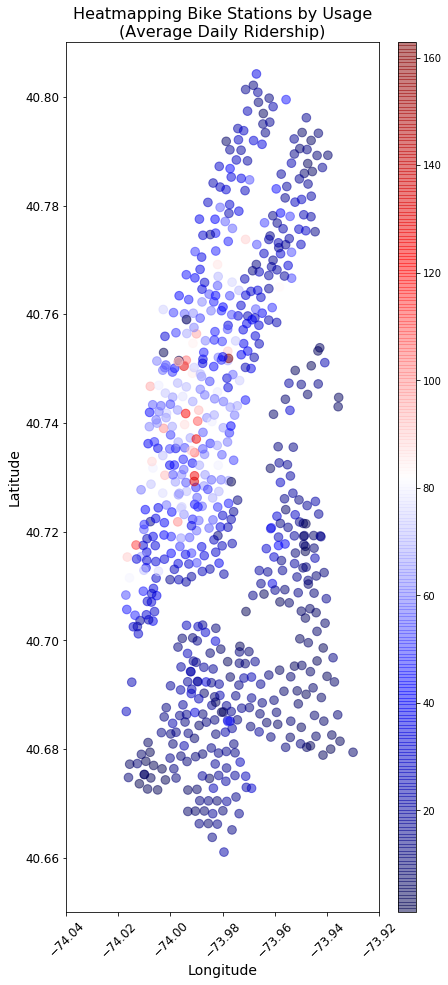

In [12]:
# Heatmap the ridership vs locations
plt.figure(figsize=(7, 16))
plt.scatter(data_loc_mean['st_longitude'], data_loc_mean['st_latitude'], s=75, alpha=0.5, 
                    c=data_loc_mean['pickups'], cmap=plt.cm.seismic)
cbar = plt.colorbar(aspect=50)
plt.xlim(-74.04, -73.92)
plt.ylim([40.65, 40.81])
title = 'Heatmapping Bike Stations by Usage\n(Average Daily Ridership)'
plt.title(title, fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

In [48]:
# Get top 10 locations for subscribers and non-subscribers
top10subs_st_ids = [519, 521, 3263, 497, 435, 293, 3230, 402, 285, 3255]
top10cust_st_ids = [2006, 387, 3143, 281, 3137, 3282, 3165, 426, 514, 3168]

In [49]:
top10subs = data[data['st_id'].isin(top10subs_st_ids)][['st_longitude', 'st_latitude']].drop_duplicates()
top10cust = data[data['st_id'].isin(top10cust_st_ids)][['st_longitude', 'st_latitude']].drop_duplicates()

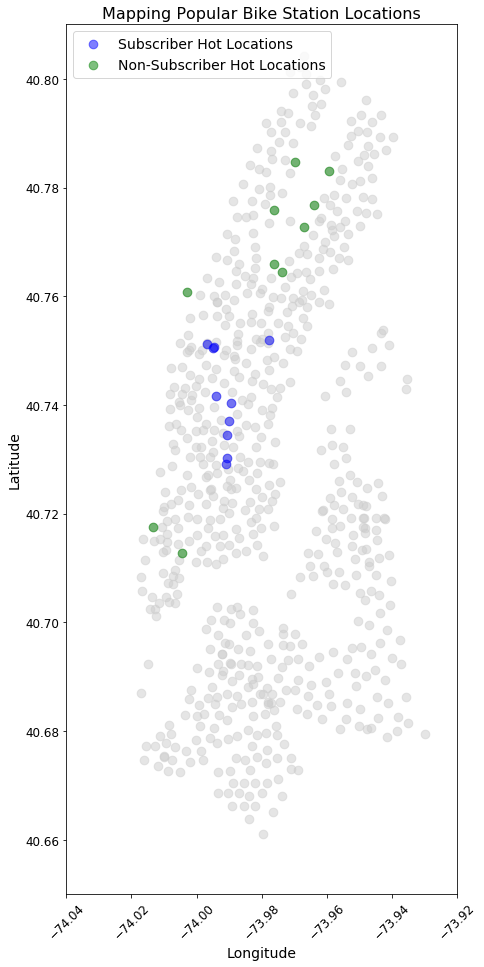

In [50]:
# mapping top10 locations
plt.figure(figsize=(7, 16))
plt.scatter(data_loc_mean['st_longitude'], data_loc_mean['st_latitude'], s=75, alpha=0.5,  c='0.8', label=None)
plt.scatter(top10subs['st_longitude'], top10subs['st_latitude'], s=75, alpha=0.5,  c='b', label='Subscriber Hot Locations')
plt.scatter(top10cust['st_longitude'], top10cust['st_latitude'], s=75, alpha=0.5,  c='g', label='Non-Subscriber Hot Locations')
plt.xlim(-74.04, -73.92)
plt.ylim([40.65, 40.81])
title = 'Mapping Popular Bike Station Locations'
plt.title(title, fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=14)